In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

import gym
import numpy as np
import random
from tqdm import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#pip install gym==0.24

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for gym: filename=gym-0.24.0-py3-none-any.whl size=790693 sha256=7cb0c3b3d36423893ac9c9bc05cc5018ea0b4780d1f6a64e895a2e4993a0301f
  Stored in directory: c:\users\laura\appdata\local\pip\cache\wheels\13\fc\17\a8d112908cf59dc2b10a0ec5cd1953a00630ff7dd2302480a1
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2
Note: you may need to restart the kernel to use updated packages.


##### **Initialize environment**

In [3]:
env = gym.make("Taxi-v3").env

[autoreload of gym.spaces.box failed: Traceback (most recent call last):
  File "C:\Users\laura\AppData\Roaming\Python\Python39\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\laura\AppData\Roaming\Python\Python39\site-packages\IPython\extensions\autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\laura\AppData\Roaming\Python\Python39\site-packages\IPython\extensions\autoreload.py", line 377, in update_generic
    update(a, b)
  File "C:\Users\laura\AppData\Roaming\Python\Python39\site-packages\IPython\extensions\autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "C:\Users\laura\AppData\Roaming\Python\Python39\site-packages\IPython\extensions\autoreload.py", line 377, in update_generic
    update(a, b)
  File "C:\Users\laura\AppData\Roaming\Python\Python39\site-packages\IPython\extensions\autoreload.py", line 289, in update_

##### **Q-agent**

In [4]:
import numpy as np

class QAgent:

    def __init__(self, env, alpha, gamma):
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros([env.observation_space.n,
                                 env.action_space.n])

        # hyper-parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor

    def get_action(self, state):
        """"""
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        """"""
        # Q-learning formula
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        new_value = \
            old_value + \
            self.alpha * (reward + self.gamma * next_max - old_value)

        # update the q_table
        self.q_table[state, action] = new_value

In [5]:
# hyper-parameters
# RL problems are full of these hyper-parameters.
# For the moment, trust me when I set these values.
# We will later play with these and see how they impact learning.
alpha = 0.1
gamma = 0.6

agent = QAgent(env, alpha, gamma)

In [6]:
# exploration vs exploitation prob
epsilon = 0.1

n_episodes = 10000

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action) 
        
        agent.update_parameters(state, action, reward, next_state)
        
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1536.12it/s]


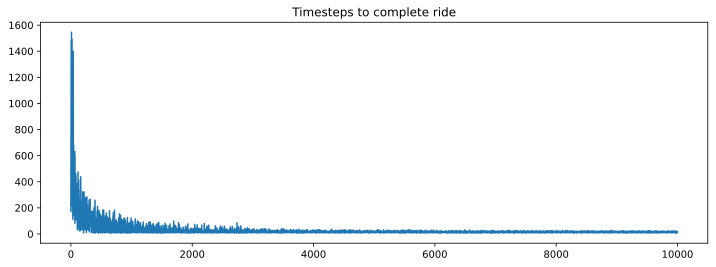

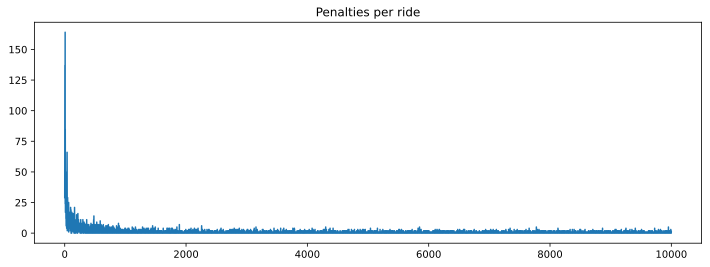

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 3))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (8, 3))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind='line')
plt.show()

##### **Start from a fixed state**

In [8]:
# set initial state of the environment
state = 123
env.s = state

epochs = 0
penalties = 0
reward = 0

# store frames to latter plot them
frames = []

done = False

while not done:
    
    action = agent.get_action(state)
    
    next_state, reward, done, info = env.step(action)
    agent.update_parameters(state, action, reward, next_state)

    if reward == -10:
        penalties += 1
    
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    state = next_state

    epochs += 1
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 8
Penalties incurred: 0


In [9]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1} of {len(frames)}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 8 of 8
State: 418
Action: 5
Reward: 20


##### **Evaluate on 100 episodes**

In [10]:
import random
from tqdm import tqdm

# exploration vs exploitation prob
epsilon = 0.05

n_episodes = 100

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()      
    
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action)
        
        #agent.update_parameters(state, action, reward, next_state)
                      
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
            
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2494.23it/s]


In [11]:
print(f'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}')
print(f'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}')

Avg steps to complete ride: 32.27
Avg penalties to complete ride: 0.43


In [12]:
from gym.version import VERSION
print(VERSION)

0.24.0
